In [1]:
import numpy as np
import pandas as pdcoding
import gzip

In [2]:
#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse
idata = SOMToolBox_Parse("datasets/iris/iris.vec").read_weight_file()
weights = SOMToolBox_Parse("datasets/iris/iris.wgt.gz").read_weight_file()

In [3]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)

%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
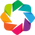

:Layout
   .Image.HitHist               :Image   [x,y]   (z)
   .Image.U_hyphen_minus_Matrix :Image   [x,y]   (z)
   .Image.SDH                   :Image   [x,y]   (z)

In [4]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

hithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) 
um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   

hv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), 
           um.relabel('U-Matrix').opts(cmap='bokeh'), sdh.relabel('SDH').opts(cmap='viridis')])

## Clustering

The aim of this section is to get together similar units into cluser

In [5]:
from bokeh.plotting import show

def plot_clusters(predicted_clusters, name="Cluster"):
    """
    Get in input a mxn array with the cluster label as value and plot the representation
    """
    cluster = hv.Image(predicted_clusters).opts(xaxis=None, yaxis=None)
    show(hv.render(hv.Layout([cluster.relabel(name)])))

### KMeans

In [6]:
from sklearn.cluster import KMeans

def find_clusters_KMeans(data, k_clusters=3):
    """
    Retunr a KMeans object fitted on the given data for a defined amount of clusters
    """
    km_classifier = KMeans(n_clusters=k_clusters, random_state=42)
    initial_labels = km_classifier.fit_predict(data)
    km_classifier.fit(data, initial_labels)

    return km_classifier

In [7]:
import warnings

warnings.filterwarnings("ignore")

# Get the cluster for each units
km_classifier = find_clusters_KMeans(weights['arr'], k_clusters=3)

kMean_clusters = km_classifier.predict(weights['arr'])
plot_clusters(kMean_clusters.reshape(weights['ydim'], weights['ydim']), 'KMean clusters')

# Get the cluster centers
# print(km_classifier.cluster_centers_)

### Hierarchical clustering

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Compute the hierarchical proximity
linkage_data = linkage(weights['arr'], method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [9]:
# Define the clusters with a distance between units parameter
hierarchical_clusters = fcluster(linkage_data, 1.153) # TODO other way to split the dendrogram 
plot_clusters(hierarchical_clusters.reshape(weights['ydim'], weights['ydim']), "Hierarchical clustering")

NameError: name 'linkage_data' is not defined

## Extracting High Mean Low Variance Attributes

### Various helper functions

In [11]:
def normalize_data(data):
    """
    Performs zero mean unit variance normalization on the given datapoints.
    Allows inter attribute comparison.

    :param data: The np array containting the data points
    :return: an np array containing normalized datapoints
    """
    normalized_data = np.copy(data)
    means = np.mean(data, axis=0)
    std_diviations = np.std(data, axis=0)
    dimensions = data.shape[1]
    for i in range(0, dimensions):
        normalized_data[:, i] = normalized_data[:, i] - means[i]
        normalized_data[:, i] = normalized_data[:, i] / std_diviations[i]
    return normalized_data

In [12]:
def assign_bmus(data, units):
    """
    Assigns each datapoint to its best matching unit.

    :param data: np array of datapoints
    :param units: np array containg the weight vectors for all units
    :return: a list containing an entry per SOM unit with the indexes of all datapoints for which the unit is the BMU
    """
    # Init assignment list
    bmu_assignments = []
    for i in range(0, units.shape[0]):
        bmu_assignments.append([])

    # Add index to closest unit's list
    for idx, data_point in enumerate(data):
        dists = np.linalg.norm(units - data_point, axis = 1)
        min_idx = np.argmin(dists)
        bmu_assignments[min_idx].append(idx)
        
    return bmu_assignments

In [13]:
def get_means(points):
    if len(points) == 0:
        return None
    elif len(points) == 1:
        return points[0]
    else:
        return np.mean(np.array(points), axis=0)

def get_standard_deviations(points):
    if len(points) == 0:
        return None
    elif len(points) == 1:
        return np.zeros_like(points[0])
    else:
        return np.std(np.array(points), axis=0)

# Avoid division by 0 for fully homogenous attributes
MIN_VARIANCE = 0.0000001

def replace_with_min_variance(array):
    res = []
    for i in array:
        if i < MIN_VARIANCE:
            res.append(MIN_VARIANCE)
        else:
            res.append(i)
    return np.array(res)

def flatten(xss):
    return [x for xs in xss for x in xs]

### Per Unit

In [14]:
def get_high_mean_low_variance_attributes_per_unit(
    data,
    units,
    num_attributes,
    mean_factor,
    variance_factor,
):
    """
    Assigns each unit the specified number of high mean low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :param mean_factor: controls impact of mean on attribute score
    :param variance_factor: controls impact of variance on attribute score
    :return: a list of attribute assignments per unit
    """
    if data.shape[1] != units.shape[1]:
        raise Exception("your datapoints and SOM units are not of the same dimension")
        
    bmu_assignments = assign_bmus(data, units)
    
    norm_data = normalize_data(data)
    normalized_assignments = [[norm_data[p] for p in a] for a in bmu_assignments]
    
    means = [get_means(a) for a in normalized_assignments]
    std_divs = [get_standard_deviations(a) for a in normalized_assignments]

    attrs = []
    for i in range(0, units.shape[0]):
        unit_means = means[i]
        unit_std_divs = std_divs[i]

        if unit_means is None or unit_std_divs is None:
            # interpolating unit -> do not label
            attrs.append(np.array([]))
            continue

        # TODO is this the smartest way to calculate this? 
        scores = (unit_means * mean_factor) + ((1.0 / replace_with_min_variance(unit_std_divs)) * variance_factor)
        
        attributes_to_take = num_attributes if num_attributes <= scores.shape[0] else scores.shape[0]
        min_attrs = np.argpartition(scores, attributes_to_take)
        attrs.append(min_attrs[:attributes_to_take])
    
    return attrs

In [15]:
def get_high_mean_attributes_per_unit(
    data,
    units,
    num_attributes,
):
    """
    Assigns each unit the specified number of high mean attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :return: a list of attribute assignments per unit
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 1, 0)

def get_low_variance_attributes_per_unit(
    data,
    units,
    num_attributes,
):
    """
    Assigns each unit the specified number of low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param num_attributes: the max number of attributes returned for each unit
    :return: a list of attribute assignments per unit
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 0, 1)

### Per Cluster

In [16]:
def match_cluster_id(predicted_clusters):
    """
    Transform the cluster predictions into a dictionary (cluster_id: unit_id)
    """
    clusters = {}
    for id, cluster_id in enumerate(predicted_clusters):
        if cluster_id not in clusters.keys():
            clusters[cluster_id] = []
        clusters[cluster_id].append(id)
        
    return clusters    

In [17]:
def get_high_mean_low_variance_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
    mean_factor,
    variance_factor,
):
    """
    Assigns each cluster the specified number of high mean low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :param mean_factor: controls impact of mean on attribute score
    :param variance_factor: controls impact of variance on attribute score
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    if data.shape[1] != units.shape[1]:
        raise Exception("your datapoints and SOM units are not of the same dimension")
        
    bmu_assignments = assign_bmus(data, units)
    norm_data = normalize_data(data)
    
    res = {}
    cluster_partition = match_cluster_id(cluster_partition)
    for cluster_id , cluster in cluster_partition.items():      
        bmu_cluster_assignments = flatten([bmu_assignments[unit_id] for unit_id in cluster])
        normalized_assignments = [norm_data[p] for p in bmu_cluster_assignments]
        
        means = get_means(normalized_assignments)
        std_divs = get_standard_deviations(normalized_assignments)
    
        if means is None or std_divs is None:
            # Unlikely case of cluster of only interpolating units
            res.append(np.array([]))
            continue
    
        scores = (means * mean_factor) + ((1.0 / replace_with_min_variance(std_divs)) * variance_factor)
            
        attributes_to_take = num_attributes if num_attributes <= scores.shape[0] else scores.shape[0]
        min_attrs = np.argpartition(scores, attributes_to_take)
        res[cluster_id] = min_attrs[:attributes_to_take]
        
    return res

In [18]:
def get_high_mean_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
):
    """
    Assigns each cluster the specified number of high mean attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 1, 0)

def get_low_variance_attributes_per_cluster(
    data,
    units,
    cluster_partition,
    num_attributes,
):
    """
    Assigns each cluster the specified number of low variance attributes.
    Attributes are given as dimension ids.
    Name mapping needs to happen saparately.
    Clusters are given as a list with the same number of elements as there are units in the SOM
    Interpolating unit without Data are assigned an empty array.

    :param data: the unnormalized datapoints
    :param units: the unnormalized weight vectors of the SOM units
    :param cluster_partition: a list of cluster assignments for each unit of the SOM
    :param num_attributes: the max number of attributes returned for each unit
    :return: a dictionary where key = cluster id and the value is the list of extracted attributes
    """
    return get_high_mean_low_variance_attributes_per_unit(data, units, num_attributes, 0, 1)

In [21]:
# Example of how to use the attribute extraction functions
attr_mappings = get_high_mean_low_variance_attributes_per_unit(idata["arr"],weights["arr"], 2, 1, 1)

# TODO we should load these form the provided files instead of hardcoding
attr_names = ["sep_length", "sep_width", "pet_length", "pet_width"]

print("per unit:")
named_mappings = [np.array([attr_names[id] for id in mapping]) for mapping in attr_mappings]
print(named_mappings)

print("per cluster:")
cluster_attr_mappings = get_high_mean_low_variance_attributes_per_cluster(idata["arr"],weights["arr"], kMean_clusters, 2, 0, 1)
named_cluster_mappings = {cluster_id:np.array([attr_names[id] for id in mapping]) for (cluster_id, mapping) in cluster_attr_mappings.items()}
print(named_cluster_mappings)

per unit:
[array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_width', 'sep_length'], dtype='<U10'), array([], dtype=float64), array(['sep_width', 'sep_length'], dtype='<U10'), array(['sep_length', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['sep_length', 'pet_length'], dtype='<U10'), array(['sep_width', 'pet_width'], dtype='<U9'), array(['pet_width', 'sep_width'], dtype='<U9'), array(['sep_width', 'pet_width'], dtype='<U9'), array([], dtype=float